In [1]:
import pickle

def load_imu_segments(file_path):
    """
    Loads labeled IMU segments from a pickle file.

    Args:
        file_path (str): The path to the pickle file.

    Returns:
        object: The object loaded from the pickle file.  This will
                likely be a list, dictionary, or custom object
                depending on how the pickle file was created.
    """
    try:
        with open(file_path, 'rb') as f:  # 'rb' for read binary
            data = pickle.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage:
file_path = 'labeled_imu_segments.pkl'
labeled_segments = load_imu_segments(file_path)

if labeled_segments:
    print("Data loaded successfully.")
    # Now you can work with the loaded_data object.
    # For example, if it's a list:
    # for item in loaded_data:
    #     print(item)
else:
    print("Failed to load data.")

Data loaded successfully.


In [38]:
import tensorflow as tf
import numpy as np
import pickle
import os

# --- Configuration ---
H5_MODEL_PATH = 'imu_cnn_model.h5'        # Input Keras model saved in HDF5 format
TFLITE_MODEL_PATH = 'imu_model.tflite'    # Output TFLite model path
TFLITE_MODEL_CC_PATH = 'imu_model.cc'   # Output TFLite C array path (optional)
SCALER_PATH = 'imu_scaler.pkl'          # Path to the saved scaler

# --- Load the Trained Keras Model ---
if not os.path.exists(H5_MODEL_PATH):
    print(f"Error: Model file not found at {H5_MODEL_PATH}")
    exit()

print(f"Loading Keras model from {H5_MODEL_PATH}...")
model = tf.keras.models.load_model(H5_MODEL_PATH)
print("Model loaded successfully.")
model.summary() # Print model summary to verify

# --- Load the Scaler (Optional here, but good practice to verify it exists) ---
if not os.path.exists(SCALER_PATH):
    print(f"Warning: Scaler file not found at {SCALER_PATH}. Conversion will proceed, but ensure you have the mean/scale values.")
else:
    print(f"Scaler file found at {SCALER_PATH}. Ensure you use its values on the MCU.")
    # Optionally load and print mean/scale here for verification if needed
    # with open(SCALER_PATH, 'rb') as f:
    #     scaler = pickle.load(f)
    # print(f"Scaler Means: {scaler.mean_}")
    # print(f"Scaler Scales: {scaler.scale_}")


# --- Convert to TensorFlow Lite ---
print("Converting model to TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply default optimizations (recommended for MCUs, often includes float16 quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# --- Optional: Integer Quantization (More complex, requires representative dataset) ---
# If DEFAULT optimizations are not small enough or you need integer math:
# 1. Load your SCALED training data (X_train_scaled from the training script)
# 2. Define a representative dataset generator:
# def representative_dataset_gen():
#     # Yield a small number (e.g., 100) of samples from SCALED training data
#     # Ensure data is float32
#     for i in range(100):
#         yield [X_train_scaled[i:i+1].astype(np.float32)] # Must be a list
#
# converter.representative_dataset = representative_dataset_gen
# # Force input and output tensors to int8 (common for MCUs)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8 # or tf.uint8
# print("INFO: Using Integer Quantization settings.")
# --- End Optional Integer Quantization ---


# Perform the conversion
try:
    tflite_model = converter.convert()
    print("Model converted successfully.")
except Exception as e:
    print(f"\n!!!!!!!! ERROR during TFLite conversion !!!!!!!!!")
    print(f"Error message: {e}")
    print("This can happen due to unsupported operations or issues during quantization.")
    print("Try without optimizations first, or ensure your representative dataset (if used) is correct.")
    print("Check TensorFlow documentation for compatibility.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit() # Stop if conversion fails


# --- Save the TFLite Model ---
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to: {TFLITE_MODEL_PATH} ({len(tflite_model)} bytes)")


# --- Optional: Convert TFLite model to C array using xxd ---
# This is often the easiest way to include the model in Arduino projects
print("\nConverting TFLite model to C source file using xxd...")
# Make sure xxd is available in your system PATH (common on Linux/macOS, installable on Windows)
try:
    # Generate C array file (e.g., imu_model.cc)
    os.system(f"xxd -i {TFLITE_MODEL_PATH} > {TFLITE_MODEL_CC_PATH}")

    # Optional: Read the C file and modify variable name for clarity
    with open(TFLITE_MODEL_CC_PATH, 'r') as f:
        c_content = f.read()
    # Replace the default variable name generated by xxd
    # (adjust 'imu_model_tflite' if your filename is different)
    c_content = c_content.replace('unsigned char imu_model_tflite[] = {',
                                  'const unsigned char g_imu_model_data[] = {')
    c_content = c_content.replace('unsigned int imu_model_tflite_len = ',
                                  'const unsigned int g_imu_model_data_len = ')
    # Add header guard and include
    c_output = f"#ifndef IMU_MODEL_DATA_H_\n#define IMU_MODEL_DATA_H_\n\n{c_content}\n#endif // IMU_MODEL_DATA_H_\n"

    with open(TFLITE_MODEL_CC_PATH.replace('.cc', '.h'), 'w') as f: # Save as .h
         f.write(c_output)

    print(f"C array saved to: {TFLITE_MODEL_CC_PATH.replace('.cc', '.h')}")
    print("You can now include this .h file in your Arduino project.")

except FileNotFoundError:
    print("\nError: 'xxd' command not found.")
    print("Please install 'xxd' (part of vim-common or similar packages)")
    print(f"or manually convert '{TFLITE_MODEL_PATH}' to a C array.")
except Exception as e:
     print(f"\nError during xxd conversion or C file modification: {e}")

Loading Keras model from imu_cnn_model.h5...
Model loaded successfully.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 45, 8)             368       
                                                                 
 dropout_12 (Dropout)        (None, 45, 8)             0         
                                                                 
 conv1d_13 (Conv1D)          (None, 45, 16)            656       
                                                                 
 dropout_13 (Dropout)        (None, 45, 16)            0         
                                                                 
 global_average_pooling1d_6  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 4)          

Total params: 1092 (4.27 KB)
Trainable params: 1092 (4.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Scaler file found at imu_scaler.pkl. Ensure you use its values on the MCU.
Converting model to TensorFlow Lite...
INFO:tensorflow:Assets written to: /tmp/tmp15xa0dqg/assets


INFO:tensorflow:Assets written to: /tmp/tmp15xa0dqg/assets


Model converted successfully.
TFLite model saved to: imu_model.tflite (8392 bytes)

Converting TFLite model to C source file using xxd...
C array saved to: imu_model.h
You can now include this .h file in your Arduino project.


2025-04-03 10:52:27.999751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-03 10:52:27.999765: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-03 10:52:27.999856: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp15xa0dqg
2025-04-03 10:52:28.000419: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-03 10:52:28.000425: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp15xa0dqg
2025-04-03 10:52:28.002348: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04-03 10:52:28.018912: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp15xa0dqg
2025-04-03 10:52:28.023984: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 24128 m


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        39
           1       0.77      0.77      0.77        57
           2       0.87      0.87      0.87        62
           3       0.80      0.84      0.82        51

    accuracy                           0.83       209
   macro avg       0.84      0.83      0.84       209
weighted avg       0.83      0.83      0.83       209



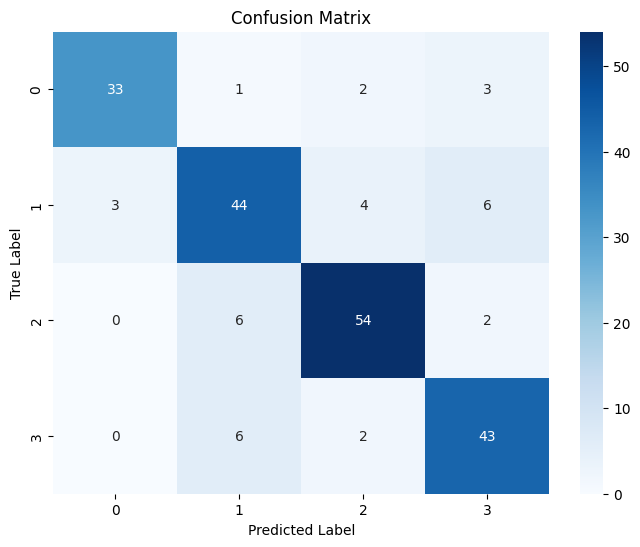

In [35]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your test data (X_test_scaled and y_test should be pre-loaded and preprocessed as before)

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="imu_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a list to collect predictions.
predictions = []

# Loop over each sample in your test set.
for i in range(len(X_test_scaled)):
    # Ensure the sample is of the expected shape and type.
    sample = np.expand_dims(X_test_scaled[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], sample)
    
    # Run inference.
    interpreter.invoke()
    
    # Retrieve the output.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

# Convert predictions list to an array.
predictions = np.vstack(predictions)

# Convert probabilities to predicted class indices.
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report.
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Compute and display confusion matrix.
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true_classes),
            yticklabels=np.unique(y_true_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [12]:
import tensorflow as tf
import numpy as np
import pickle
import os

# --- Configuration ---
H5_MODEL_PATH = 'imu_cnn_model.h5'        # Input Keras model saved in HDF5 format
TFLITE_MODEL_PATH = 'imu_model.tflite'    # Output TFLite model path
TFLITE_MODEL_CC_PATH = 'imu_model.cc'   # Output TFLite C array path (optional)
SCALER_PATH = 'imu_scaler.pkl'          # Path to the saved scaler

# --- Load the Trained Keras Model ---
if not os.path.exists(H5_MODEL_PATH):
    print(f"Error: Model file not found at {H5_MODEL_PATH}")
    exit()

print(f"Loading Keras model from {H5_MODEL_PATH}...")
model = tf.keras.models.load_model(H5_MODEL_PATH)
print("Model loaded successfully.")
model.summary() # Print model summary to verify

# --- Load the Scaler (Optional here, but good practice to verify it exists) ---
if not os.path.exists(SCALER_PATH):
    print(f"Warning: Scaler file not found at {SCALER_PATH}. Conversion will proceed, but ensure you have the mean/scale values.")
else:
    print(f"Scaler file found at {SCALER_PATH}. Ensure you use its values on the MCU.")
    # Optionally load and print mean/scale here for verification if needed
    # with open(SCALER_PATH, 'rb') as f:
    #     scaler = pickle.load(f)
    # print(f"Scaler Means: {scaler.mean_}")
    # print(f"Scaler Scales: {scaler.scale_}")


# --- Convert to TensorFlow Lite ---
print("Converting model to TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply default optimizations (recommended for MCUs, often includes float16 quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# --- Optional: Integer Quantization (More complex, requires representative dataset) ---
# If DEFAULT optimizations are not small enough or you need integer math:
# 1. Load your SCALED training data (X_train_scaled from the training script)
# 2. Define a representative dataset generator:
# def representative_dataset_gen():
#     # Yield a small number (e.g., 100) of samples from SCALED training data
#     # Ensure data is float32
#     for i in range(100):
#         yield [X_train_scaled[i:i+1].astype(np.float32)] # Must be a list
#
# converter.representative_dataset = representative_dataset_gen
# # Force input and output tensors to int8 (common for MCUs)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8 # or tf.uint8
# print("INFO: Using Integer Quantization settings.")
# --- End Optional Integer Quantization ---


# Perform the conversion
try:
    tflite_model = converter.convert()
    print("Model converted successfully.")
except Exception as e:
    print(f"\n!!!!!!!! ERROR during TFLite conversion !!!!!!!!!")
    print(f"Error message: {e}")
    print("This can happen due to unsupported operations or issues during quantization.")
    print("Try without optimizations first, or ensure your representative dataset (if used) is correct.")
    print("Check TensorFlow documentation for compatibility.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit() # Stop if conversion fails


# --- Save the TFLite Model ---
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved to: {TFLITE_MODEL_PATH} ({len(tflite_model)} bytes)")


# --- Optional: Convert TFLite model to C array using xxd ---
# This is often the easiest way to include the model in Arduino projects
print("\nConverting TFLite model to C source file using xxd...")
# Make sure xxd is available in your system PATH (common on Linux/macOS, installable on Windows)
try:
    # Generate C array file (e.g., imu_model.cc)
    os.system(f"xxd -i {TFLITE_MODEL_PATH} > {TFLITE_MODEL_CC_PATH}")

    # Optional: Read the C file and modify variable name for clarity
    with open(TFLITE_MODEL_CC_PATH, 'r') as f:
        c_content = f.read()
    # Replace the default variable name generated by xxd
    # (adjust 'imu_model_tflite' if your filename is different)
    c_content = c_content.replace('unsigned char imu_model_tflite[] = {',
                                  'const unsigned char g_imu_model_data[] = {')
    c_content = c_content.replace('unsigned int imu_model_tflite_len = ',
                                  'const unsigned int g_imu_model_data_len = ')
    # Add header guard and include
    c_output = f"#ifndef IMU_MODEL_DATA_H_\n#define IMU_MODEL_DATA_H_\n\n{c_content}\n#endif // IMU_MODEL_DATA_H_\n"

    with open(TFLITE_MODEL_CC_PATH.replace('.cc', '.h'), 'w') as f: # Save as .h
         f.write(c_output)

    print(f"C array saved to: {TFLITE_MODEL_CC_PATH.replace('.cc', '.h')}")
    print("You can now include this .h file in your Arduino project.")

except FileNotFoundError:
    print("\nError: 'xxd' command not found.")
    print("Please install 'xxd' (part of vim-common or similar packages)")
    print(f"or manually convert '{TFLITE_MODEL_PATH}' to a C array.")
except Exception as e:
     print(f"\nError during xxd conversion or C file modification: {e}")

Loading Keras model from imu_cnn_model.h5...
Model loaded successfully.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 45, 8)          368       
                                                                 
 dropout_10 (Dropout)        (None, 1, 45, 8)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 45, 16)         656       
                                                                 
 dropout_11 (Dropout)        (None, 1, 45, 16)         0         
                                                                 
 global_avg_pool (GlobalAve  (None, 16)                0         
 ragePooling2D)                                                  
                                                                 
 output_dense (Dense)        (None, 4)          

INFO:tensorflow:Assets written to: /tmp/tmpohd_biiv/assets
2025-04-03 13:35:32.675133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-03 13:35:32.675147: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Model converted successfully.
TFLite model saved to: imu_model.tflite (13292 bytes)

Converting TFLite model to C source file using xxd...
C array saved to: imu_model.h
You can now include this .h file in your Arduino project.


2025-04-03 13:35:32.675239: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpohd_biiv
2025-04-03 13:35:32.676011: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-03 13:35:32.676017: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpohd_biiv
2025-04-03 13:35:32.678370: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04-03 13:35:32.698102: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpohd_biiv
2025-04-03 13:35:32.704389: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 29149 microseconds.


TensorFlow Version: 2.13.1
!!!!!!!!!!!!!!!!!
!!! No GPU found using `tf.config.list_physical_devices('GPU')`.
!!! Training will proceed on CPU.
!!! Check TensorFlow installation, NVIDIA drivers, CUDA, and cuDNN.
!!!!!!!!!!!!!!!!!
Successfully loaded data from 'labeled_imu_segments.pkl' (1390 segments)
Detected segment shape: (45, 9)
Labels encoded.
Class mapping: {0: 'jump', 1: 'null', 2: 'spin', 3: 'weave'}
Target model input shape: (1, 45, 9)
Data split (before reshape): Train=(903, 45, 9), Validation=(278, 45, 9), Test=(209, 45, 9)
Data scaled using StandardScaler (fitted on training data).
Reshaping data to add dimension for TFLM Conv2D compatibility...
Data shapes after reshape: Train=(903, 1, 45, 9), Validation=(278, 1, 45, 9), Test=(209, 1, 45, 9)
Calculated Class Weights: {0: 1.3279411764705882, 1: 0.9214285714285714, 2: 0.8392193308550185, 3: 1.0308219178082192}
Building model with Input shape: (1, 45, 9)
Model: "sequential_7"
__________________________________________________


--- Starting Training ---
Epoch 1/100
 1/57 [..............................] - ETA: 12s - loss: 1.4176 - accuracy: 0.1875
Epoch 1: val_loss improved from inf to 1.28612, saving model to imu_cnn_model.h5
57/57 [==============================] - 0s 2ms/step - loss: 1.3519 - accuracy: 0.2414 - val_loss: 1.2861 - val_accuracy: 0.3489
Epoch 2/100
 1/57 [..............................] - ETA: 0s - loss: 1.3094 - accuracy: 0.1875
Epoch 2: val_loss improved from 1.28612 to 1.14678, saving model to imu_cnn_model.h5
57/57 [==============================] - 0s 1ms/step - loss: 1.2452 - accuracy: 0.3920 - val_loss: 1.1468 - val_accuracy: 0.5647
Epoch 3/100
 1/57 [..............................] - ETA: 0s - loss: 1.1196 - accuracy: 0.6250
Epoch 3: val_loss improved from 1.14678 to 1.01797, saving model to imu_cnn_model.h5
57/57 [==============================] - 0s 1ms/step - loss: 1.1392 - accuracy: 0.5604 - val_loss: 1.0180 - val_accuracy: 0.6187
Epoch 4/100
 1/57 [..............................

/home/aden/anaconda3/envs/TFenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 0.94062 to 0.90207, saving model to imu_cnn_model.h5
57/57 [==============================] - 0s 1ms/step - loss: 0.9959 - accuracy: 0.6168 - val_loss: 0.9021 - val_accuracy: 0.6727
Epoch 6/100
 1/57 [..............................] - ETA: 0s - loss: 0.8924 - accuracy: 0.6875
Epoch 6: val_loss improved from 0.90207 to 0.87330, saving model to imu_cnn_model.h5
57/57 [==============================] - 0s 1ms/step - loss: 0.9499 - accuracy: 0.6689 - val_loss: 0.8733 - val_accuracy: 0.6871
Epoch 7/100
 1/57 [..............................] - ETA: 0s - loss: 1.1125 - accuracy: 0.5000
Epoch 7: val_loss improved from 0.87330 to 0.81669, saving model to imu_cnn_model.h5
57/57 [==============================] - 0s 1ms/step - loss: 0.9156 - accuracy: 0.6622 - val_loss: 0.8167 - val_accuracy: 0.7014
Epoch 8/100
 1/57 [..............................] - ETA: 0s - loss: 0.7488 - accuracy: 0.8125
Epoch 8: val_loss improved from 0.81669 to 0.79247, saving model to imu_

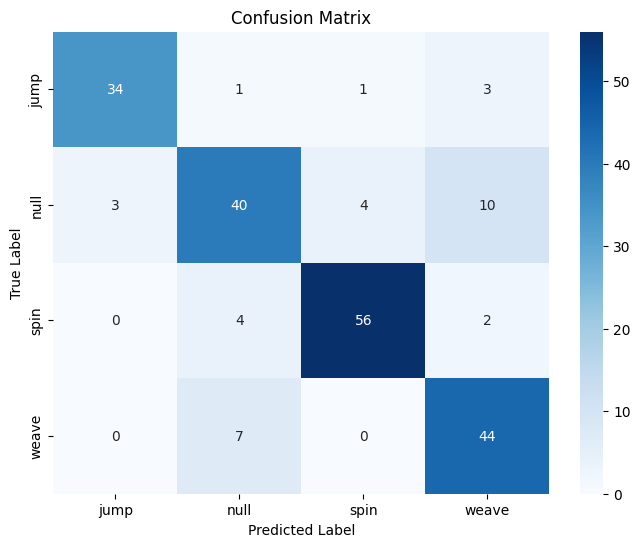

Scaler saved to 'imu_scaler.pkl'

--- Normalization Constants for C++ ---
const float FEATURE_MEANS[NUM_FEATURES] = {
    1.20960010e-01, 7.94896026e-01, -5.09449145e+00, 7.74947705e-04, 1.49835118e-01, -4.48857635e-01, -3.34466937e+00, -4.57668365e+00, -2.40626536e+01  // ax, ay, az, gx, gy, gz, mx, my, mz means
};
const float FEATURE_SCALES[NUM_FEATURES] = {
    7.87378730e+00, 1.02205258e+01, 7.44162342e+00, 2.05283428e+00, 3.50854654e+00, 2.14226314e+00, 3.05463829e+01, 3.34312034e+01, 2.82488909e+01  // ax, ay, az, gx, gy, gz, mx, my, mz scales (std dev)
};
Label encoder saved to 'imu_label_encoder.pkl'
Class mapping: {0: 'jump', 1: 'null', 2: 'spin', 3: 'weave'}

--- Converting Model to TensorFlow Lite ---
Successfully loaded best model from 'imu_cnn_model.h5' for conversion.
INFO:tensorflow:Assets written to: /tmp/tmpesswi5sf/assets


INFO:tensorflow:Assets written to: /tmp/tmpesswi5sf/assets


Model successfully converted to TensorFlow Lite format.
TFLite model saved to 'imu_model.tflite' (7056 bytes)

To convert to C array, run in your terminal:
xxd -i imu_model.tflite > imu_model.h


2025-04-03 14:49:02.219699: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-03 14:49:02.219713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-03 14:49:02.219798: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpesswi5sf
2025-04-03 14:49:02.220371: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-03 14:49:02.220376: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpesswi5sf
2025-04-03 14:49:02.222024: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04-03 14:49:02.238284: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpesswi5sf
2025-04-03 14:49:02.242934: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 23135 m

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
# Highlight: Import TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout,
    GlobalAveragePooling1D, GlobalAveragePooling2D, Reshape # Keep Reshape for now
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration (Keep as before) ---
PICKLE_FILE = 'labeled_imu_segments.pkl'
MODEL_SAVE_PATH = 'imu_cnn_model.h5'     # <-- USE .h5 extension
SCALER_SAVE_PATH = 'imu_scaler.pkl'
LABEL_ENCODER_SAVE_PATH = 'imu_label_encoder.pkl'
N_CLASSES = 4
EPOCHS = 100
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.15

# --- Functions (Keep load_pickle_data, prepare_data, scale_data) ---

def load_pickle_data(filepath):
    """Loads data from a pickle file."""
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        print(f"Successfully loaded data from '{filepath}' ({len(data)} segments)")
        return data
    except Exception as e:
        print(f"Error loading pickle file '{filepath}': {e}")
        return None

def prepare_data(labeled_segments):
    """Separates data and labels, encodes labels."""
    if not labeled_segments:
        return None, None, None

    # Check data integrity (shape)
    first_shape = labeled_segments[0]['data'].shape
    if len(first_shape) != 2 or first_shape[1] != 9:
         print(f"Error: Unexpected data shape in first segment: {first_shape}. Expected (timesteps, 9)")
         return None, None, None
    timesteps = first_shape[0]
    features = first_shape[1]
    print(f"Detected segment shape: ({timesteps}, {features})")

    X = []
    y_labels = []
    for segment in labeled_segments:
         # Ensure all data has the expected shape before adding
         if segment['data'].shape == (timesteps, features):
              X.append(segment['data'])
              y_labels.append(segment['label'])
         else:
              print(f"Warning: Skipping segment with unexpected shape {segment['data'].shape}")


    if not X:
         print("Error: No valid data segments found after shape check.")
         return None, None, None

    X = np.array(X) # Shape: (num_samples, timesteps, features)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)
    y_one_hot = to_categorical(y_encoded, num_classes=N_CLASSES)

    print("Labels encoded.")
    print("Class mapping:", {i: c for i, c in enumerate(label_encoder.classes_)})

    return X, y_one_hot, label_encoder, timesteps, features

def scale_data(X_train, X_val, X_test, n_features):
    """Fits StandardScaler on training data and transforms all sets."""
    orig_shape_train = X_train.shape
    orig_shape_val = X_val.shape
    orig_shape_test = X_test.shape

    # Reshape to 2D for scaler
    X_train_reshaped = X_train.reshape(-1, n_features)
    X_val_reshaped = X_val.reshape(-1, n_features)
    X_test_reshaped = X_test.reshape(-1, n_features)

    scaler = StandardScaler()
    scaler.fit(X_train_reshaped)

    X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
    X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
    X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

    # Reshape back to original 3D shape
    X_train_scaled = X_train_scaled_reshaped.reshape(orig_shape_train)
    X_val_scaled = X_val_scaled_reshaped.reshape(orig_shape_val)
    X_test_scaled = X_test_scaled_reshaped.reshape(orig_shape_test)

    print("Data scaled using StandardScaler (fitted on training data).")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


def build_cnn_model(input_shape, num_classes):
    """
    Builds a CNN model without an explicit Reshape layer. This version assumes
    the input data is already in the shape (1, timesteps, features).
    """
    print(f"Building model with Input shape: {input_shape}")  # input_shape should be (1, timesteps, features), e.g., (1,45,9)
    model = Sequential([
        Input(shape=input_shape),  # e.g., (1,45,9)
        tf.keras.layers.Conv2D(filters=8, kernel_size=(1, 5), activation='relu', padding='same', name='conv2d_1'),
        Dropout(0.2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 5), activation='relu', padding='same', name='conv2d_2'),
        Dropout(0.25),
        GlobalAveragePooling2D(name='global_avg_pool'),
        Dense(num_classes, activation='softmax', name='output_dense')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# --- Main Execution ---

if __name__ == "__main__":

    # <<<--- GPU Check (Keep as before) --->>>
    print("TensorFlow Version:", tf.__version__)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"Found {len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s)")
            print("GPU acceleration will be used.")
        except RuntimeError as e:
            print("GPU Memory Growth Error:", e)
            print("Will proceed without memory growth setting.")
    else:
        print("!!!!!!!!!!!!!!!!!")
        print("!!! No GPU found using `tf.config.list_physical_devices('GPU')`.")
        print("!!! Training will proceed on CPU.")
        print("!!! Check TensorFlow installation, NVIDIA drivers, CUDA, and cuDNN.")
        print("!!!!!!!!!!!!!!!!!")
    # <<<--- GPU Check End --->>>


    # 1. Load Data
    labeled_segments = load_pickle_data(PICKLE_FILE)
    if labeled_segments is None:
        exit()

    # 2. Prepare Data (Separate X/y, Encode Labels)
    X, y_one_hot, label_encoder, timesteps, features = prepare_data(labeled_segments)
    if X is None:
        exit()
    # X shape here is (num_samples, timesteps, features)

    # <<<--- *** CHANGE 1: Define the target INPUT_SHAPE for the model *** --->>>
    # This is the shape TFLM Conv2D op expects for Conv1D input
    INPUT_SHAPE = (1, timesteps, features)
    print(f"Target model input shape: {INPUT_SHAPE}")

    # Get integer labels for stratification and class weights
    y_integers = np.argmax(y_one_hot, axis=1)

    # 3. Split Data (Train, Validation, Test)
    # Data is still (num_samples, timesteps, features) here
    X_train_val, X_test, y_train_val, y_test, y_int_train_val, y_int_test = train_test_split(
        X, y_one_hot, y_integers,
        test_size=TEST_SPLIT, random_state=42, stratify=y_integers
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=VALIDATION_SPLIT / (1.0 - TEST_SPLIT), random_state=42,
        stratify=y_int_train_val
    )
    print(f"Data split (before reshape): Train={X_train.shape}, Validation={X_val.shape}, Test={X_test.shape}")

    # 4. Scale/Normalize Data
    # Data remains (num_samples, timesteps, features) after scaling
    X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_data(
        X_train, X_val, X_test, features
    )

    # <<<--- *** CHANGE 2: Reshape the scaled data to match the INPUT_SHAPE *** --->>>
    print("Reshaping data to add dimension for TFLM Conv2D compatibility...")
    X_train_final = X_train_scaled.reshape((-1, 1, timesteps, features))
    X_val_final = X_val_scaled.reshape((-1, 1, timesteps, features))
    X_test_final = X_test_scaled.reshape((-1, 1, timesteps, features))
    print(f"Data shapes after reshape: Train={X_train_final.shape}, Validation={X_val_final.shape}, Test={X_test_final.shape}")


    # 5. Calculate Class Weights for Imbalance
    y_train_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced', classes=np.unique(y_train_integers), y=y_train_integers
    )
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Calculated Class Weights: {class_weight_dict}")

    # 6. Build Model (Pass the new INPUT_SHAPE)
    model = build_cnn_model(INPUT_SHAPE, N_CLASSES)
    model.summary() # Check model architecture, notice the input/output shapes

    # 7. Define Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)

    # 8. Train Model (Use the reshaped data X_train_final, X_val_final)
    print("\n--- Starting Training ---")
    history = model.fit(
        X_train_final, y_train, # <<<--- Use reshaped data
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val_final, y_val), # <<<--- Use reshaped data
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weight_dict,
        verbose=1
    )
    print("--- Training Finished ---")

    # 9. Evaluate Model (Use the reshaped test data X_test_final)
    print("\n--- Evaluating Model on Test Set ---")
    loss, accuracy = model.evaluate(X_test_final, y_test, verbose=0) # <<<--- Use reshaped data
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate predictions and classification report
    y_pred_probs = model.predict(X_test_final) # <<<--- Use reshaped data
    y_pred_int = np.argmax(y_pred_probs, axis=1)
    y_test_int = np.argmax(y_test, axis=1) # Already have y_int_test, use that
    print("\nClassification Report:")
    print(classification_report(y_int_test, y_pred_int, target_names=label_encoder.classes_))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_int_test, y_pred_int)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


    # 10. Save Scaler and Label Encoder
    with open(SCALER_SAVE_PATH, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to '{SCALER_SAVE_PATH}'")
    # Print scaler means/scales needed for C++ code
    print("\n--- Normalization Constants for C++ ---")
    print("const float FEATURE_MEANS[NUM_FEATURES] = {")
    print("   ", ", ".join([f"{m:.8e}" for m in scaler.mean_]), " // ax, ay, az, gx, gy, gz, mx, my, mz means")
    print("};")
    print("const float FEATURE_SCALES[NUM_FEATURES] = {")
    print("   ", ", ".join([f"{s:.8e}" for s in scaler.scale_]), " // ax, ay, az, gx, gy, gz, mx, my, mz scales (std dev)")
    print("};")

    with open(LABEL_ENCODER_SAVE_PATH, 'wb') as f:
        pickle.dump(label_encoder, f)
    print(f"Label encoder saved to '{LABEL_ENCODER_SAVE_PATH}'")
    print("Class mapping:", {i: c for i, c in enumerate(label_encoder.classes_)})


    # --- TensorFlow Lite Conversion ---
    print("\n--- Converting Model to TensorFlow Lite ---")

    # Load the best saved model
    # It's better to load the saved model to ensure we convert the best one
    try:
        best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
        print(f"Successfully loaded best model from '{MODEL_SAVE_PATH}' for conversion.")
    except Exception as e:
        print(f"Error loading saved model '{MODEL_SAVE_PATH}': {e}")
        print("Attempting to convert the model currently in memory (might not be the best one).")
        best_model = model # Fallback to model in memory

    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
    # Optional: Add optimizations (e.g., quantization) if needed later
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Define a representative dataset generator (using reshaped validation data)
    def representative_dataset_gen():
        # Use a subset for efficiency, ensure it's float32 and correctly shaped
        # Using X_val_final which is already scaled and reshaped
        num_samples = X_val_final.shape[0]
        samples_to_use = min(100, num_samples) # Use up to 100 samples
        indices = np.random.choice(num_samples, samples_to_use, replace=False)
        for i in indices:
            # Yield samples one by one, adding batch dimension (size 1)
             yield [X_val_final[i:i+1].astype(np.float32)] # <<<--- Use reshaped data

    # Enable representative dataset for quantization (if needed, requires optimizations)
    # If you only use DEFAULT optimization without quantization, you might not need this.
    # But it's good practice if you might quantize later.
    # converter.representative_dataset = representative_dataset_gen
    # Uncomment below if doing INT8 quantization
    # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # converter.inference_input_type = tf.int8 # or tf.uint8
    # converter.inference_output_type = tf.int8 # or tf.uint8

    try:
        tflite_model = converter.convert()
        print("Model successfully converted to TensorFlow Lite format.")

        # Save the TFLite model
        tflite_model_path = 'imu_model.tflite'
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)
        print(f"TFLite model saved to '{tflite_model_path}' ({len(tflite_model)} bytes)")

        # Optional: Convert to C array using xxd
        print("\nTo convert to C array, run in your terminal:")
        print(f"xxd -i {tflite_model_path} > imu_model.h")

    except Exception as e:
        print(f"\n!!! Error during TFLite conversion: {e}")
        print("Check model layers, input shapes, and TensorFlow version compatibility.")

In [16]:
# --- Optional: Convert TFLite model to C array using xxd ---
# This is often the easiest way to include the model in Arduino projects
print("\nConverting TFLite model to C source file using xxd...")
# Make sure xxd is available in your system PATH (common on Linux/macOS, installable on Windows)
try:
    # Generate C array file (e.g., imu_model.cc)
    os.system(f"xxd -i {TFLITE_MODEL_PATH} > {TFLITE_MODEL_CC_PATH}")

    # Optional: Read the C file and modify variable name for clarity
    with open(TFLITE_MODEL_CC_PATH, 'r') as f:
        c_content = f.read()
    # Replace the default variable name generated by xxd
    # (adjust 'imu_model_tflite' if your filename is different)
    c_content = c_content.replace('unsigned char imu_model_tflite[] = {',
                                  'const unsigned char g_imu_model_data[] = {')
    c_content = c_content.replace('unsigned int imu_model_tflite_len = ',
                                  'const unsigned int g_imu_model_data_len = ')
    # Add header guard and include
    c_output = f"#ifndef IMU_MODEL_DATA_H_\n#define IMU_MODEL_DATA_H_\n\n{c_content}\n#endif // IMU_MODEL_DATA_H_\n"

    with open(TFLITE_MODEL_CC_PATH.replace('.cc', '.h'), 'w') as f: # Save as .h
         f.write(c_output)

    print(f"C array saved to: {TFLITE_MODEL_CC_PATH.replace('.cc', '.h')}")
    print("You can now include this .h file in your Arduino project.")

except FileNotFoundError:
    print("\nError: 'xxd' command not found.")
    print("Please install 'xxd' (part of vim-common or similar packages)")
    print(f"or manually convert '{TFLITE_MODEL_PATH}' to a C array.")
except Exception as e:
     print(f"\nError during xxd conversion or C file modification: {e}")


Converting TFLite model to C source file using xxd...
C array saved to: imu_model.h
You can now include this .h file in your Arduino project.


2025-04-04 07:21:01.494136: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 07:21:01.495231: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 07:21:01.516324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 07:21:01.516795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 07:21:01.889644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

TensorFlow Version: 2.13.1
!!! No GPU found. Training on CPU. !!!
Successfully loaded data from 'labeled_imu_segments.pkl' (1390 segments)
Detected segment shape: (45, 9)
Labels encoded.
Class mapping: {0: 'jump', 1: 'null', 2: 'spin', 3: 'weave'}
Using Explicit 2D Input shape for Keras model: (1, 45, 9)

--- Debugging y_one_hot ---
Type of y_one_hot: <class 'numpy.ndarray'>
Shape of y_one_hot before argmax: (1390, 4)
Dimensions (ndim) of y_one_hot before argmax: 2
Sample of y_one_hot (first 5 rows):
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
--- End Debugging ---

Shape of y_integers after argmax: (1390,)
Data split (Augmented): Train=903, Val=278, Test=209
Data scaled using StandardScaler (fitted on training data).
Reshaping data to 4D (batch, 1, timesteps, features)...
Data shapes after reshape: Train=(903, 1, 45, 9), Val=(278, 1, 45, 9), Test=(209, 1, 45, 9)
Class Weights: {0: 1.3357988165680474, 1: 0.9176829268292683, 2: 0.8392193308550185, 3: 1.03

2025-04-04 07:21:02.227022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-04 07:21:02.227180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-04 07:21:02.249922: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

Model wrapped for pruning:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 1, 45, 8)          730       
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dropou  (None, 1, 45, 8)          1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d  (None, 1, 45, 16)         1298      
 _2 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dropou  (None, 1, 45, 16)         1         
 t_1 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_global  

/home/aden/anaconda3/envs/TFenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: saving model to imu_cnn_model_pruned_pruning.h5
57/57 [==============================] - 0s 2ms/step - loss: 1.2622 - accuracy: 0.4297 - val_loss: 1.2163 - val_accuracy: 0.4964
Epoch 4/120
 1/57 [..............................] - ETA: 0s - loss: 1.2181 - accuracy: 0.4375
Epoch 4: saving model to imu_cnn_model_pruned_pruning.h5
57/57 [==============================] - 0s 2ms/step - loss: 1.2009 - accuracy: 0.4684 - val_loss: 1.1469 - val_accuracy: 0.4964
Epoch 5/120
 1/57 [..............................] - ETA: 0s - loss: 1.1756 - accuracy: 0.6250
Epoch 5: saving model to imu_cnn_model_pruned_pruning.h5
57/57 [==============================] - 0s 2ms/step - loss: 1.1492 - accuracy: 0.4806 - val_loss: 1.1144 - val_accuracy: 0.5108
Epoch 6/120
 1/57 [..............................] - ETA: 0s - loss: 1.2334 - accuracy: 0.3750
Epoch 6: saving model to imu_cnn_model_pruned_pruning.h5
57/57 [==============================] - 0s 2ms/step - loss: 1.1051 - accuracy: 0.4817 - val_loss: 

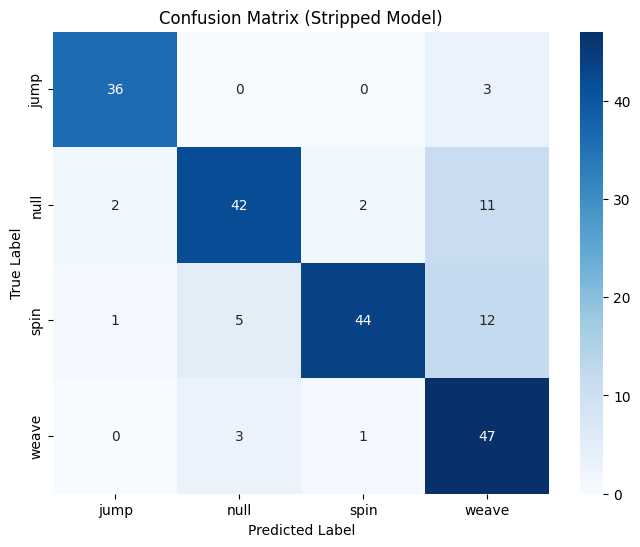

Scaler saved to 'imu_scaler_pruned.pkl'
Label encoder saved to 'imu_label_encoder_pruned.pkl'

--- Normalization Constants for C++ ---
// Constants generated from scaler: imu_scaler_pruned.pkl
const float FEATURE_MEANS[NUM_FEATURES] = {
    -5.59217423e-02, 1.16576129e+00, -5.07616267e+00, -4.03543743e-02, 2.04697674e-01, -4.87264427e-01, -3.60985407e+00, -2.80538058e+00, -2.33431101e+01  // ax, ay, az,... means
};
const float FEATURE_SCALES[NUM_FEATURES] = {
    7.91380806e+00, 1.02338530e+01, 7.61295134e+00, 2.09523183e+00, 3.55369937e+00, 2.12962856e+00, 3.01921328e+01, 3.48021246e+01, 2.83512230e+01  // ax, ay, az,... scales (std dev)
};
const char* LABELS[NUM_CLASSES] = { "jump", "null", "spin", "weave" };
#define NUM_TIMESTEPS 45
#define NUM_FEATURES 9
#define NUM_CLASSES 4

--- Converting Final Stripped Model to TensorFlow Lite ---
INFO:tensorflow:Assets written to: /tmp/tmpaggzeesp/assets


INFO:tensorflow:Assets written to: /tmp/tmpaggzeesp/assets


Stripped model successfully converted to TensorFlow Lite format.
Pruned TFLite model saved to 'imu_model_pruned.tflite' (7224 bytes)

Converting 'imu_model_pruned.tflite' to 'imu_model.h' using xxd...
Successfully created C header file 'imu_model.h'
IMPORTANT: Manually edit 'imu_model.h' to ensure the array
           is named 'g_imu_model_data' and the length variable is present.


2025-04-04 07:21:15.017412: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-04 07:21:15.017425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-04 07:21:15.017573: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaggzeesp
2025-04-04 07:21:15.018108: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-04 07:21:15.018114: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpaggzeesp
2025-04-04 07:21:15.019590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-04-04 07:21:15.019883: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04-04 07:21:15.031252: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpaggzeesp
2025-04

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import tensorflow as tf
# --- TFMOT Import ---
import tensorflow_model_optimization as tfmot
# --- End TFMOT Import ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard # Added TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import datetime # For TensorBoard logs

# --- Configuration (Update filenames) ---
PICKLE_FILE = 'labeled_imu_segments.pkl' # <<< USE AUGMENTED DATA
MODEL_SAVE_PATH = 'imu_cnn_model_pruned.h5'      # <<< New model name
SCALER_SAVE_PATH = 'imu_scaler_pruned.pkl'       # <<< New scaler name
LABEL_ENCODER_SAVE_PATH = 'imu_label_encoder_pruned.pkl' # <<< New encoder name
TFLITE_MODEL_PATH = 'imu_model_pruned.tflite'      # <<< New tflite name
CHEADER_FILE_PATH = 'imu_model.h'                # <<< Keep output C header name
N_CLASSES = 4
EPOCHS = 120 # <<< May need slightly more epochs for pruning
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2 # Use fraction of the *loaded* data
TEST_SPLIT = 0.15      # Use fraction of the *original* (pre-split) data size concept

# --- Pruning Configuration ---
PRUNING_INITIAL_SPARSITY = 0.50 # Start with 50% sparsity
PRUNING_FINAL_SPARSITY = 0.80   # Target 80% sparsity
PRUNING_BEGIN_STEP = 0          # Start pruning immediately (or set to e.g., 2 epochs * steps_per_epoch)
PRUNING_END_STEP = -1           # End pruning at the end of training (or set specific step)
PRUNING_FREQUENCY = 100         # How often to update pruning mask (steps)

# --- Functions (load_pickle_data, prepare_data, scale_data - modify prepare_data slightly) ---
def load_pickle_data(filepath):
    # (Same as before)
    if not os.path.exists(filepath): print(f"Error: File not found at {filepath}"); return None
    try:
        with open(filepath, 'rb') as f: data = pickle.load(f)
        print(f"Successfully loaded data from '{filepath}' ({len(data)} segments)")
        return data
    except Exception as e: print(f"Error loading pickle file '{filepath}': {e}"); return None

def prepare_data(labeled_segments):
    # (Same as before, just extracts data/labels)
    if not labeled_segments: return None, None, None, None, None
    first_shape = labeled_segments[0]['data'].shape
    if len(first_shape) != 2 or first_shape[1] != 9:
         print(f"Error: Unexpected data shape: {first_shape}. Expected (timesteps, 9)"); return None, None, None, None, None
    timesteps = first_shape[0]; features = first_shape[1]
    print(f"Detected segment shape: ({timesteps}, {features})")
    X = []; y_labels = []
    for segment in labeled_segments:
         if segment['data'].shape == (timesteps, features):
              X.append(segment['data']); y_labels.append(segment['label'])
         else: print(f"Warning: Skipping segment shape {segment['data'].shape}")
    if not X: print("Error: No valid segments."); return None, None, None, None, None
    X = np.array(X); label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)
    y_one_hot = to_categorical(y_encoded, num_classes=N_CLASSES)
    print("Labels encoded."); print("Class mapping:", dict(enumerate(label_encoder.classes_)))
    return X, y_one_hot, label_encoder, timesteps, features

def scale_data(X_train, X_val, X_test, n_features):
   # --- IMPORTANT: Fit scaler ONLY on TRAINING data ---
    orig_shape_train = X_train.shape; orig_shape_val = X_val.shape; orig_shape_test = X_test.shape
    X_train_reshaped = X_train.reshape(-1, n_features)
    # Only transform val/test, don't reshape them yet if they are None
    X_val_reshaped = X_val.reshape(-1, n_features) if X_val is not None else None
    X_test_reshaped = X_test.reshape(-1, n_features) if X_test is not None else None

    scaler = StandardScaler(); scaler.fit(X_train_reshaped) # Fit ONLY on training data

    X_train_scaled = scaler.transform(X_train_reshaped).reshape(orig_shape_train)
    X_val_scaled = scaler.transform(X_val_reshaped).reshape(orig_shape_val) if X_val is not None else None
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(orig_shape_test) if X_test is not None else None

    print("Data scaled using StandardScaler (fitted on training data).");
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# --- Model Definition (Explicit Conv2D - NO CHANGE NEEDED HERE) ---
def build_cnn_model_explicit_2d(input_shape_2d, num_classes, timesteps):
    # (Same as your previous explicit 2D model definition)
    print(f"Building explicit 2D model with Input shape: {input_shape_2d}")
    model = Sequential([
        Input(shape=input_shape_2d, name='input_layer_2d'),
        Conv2D(filters=8, kernel_size=(1, 5), activation='relu', padding='same', name='conv2d_1'),
        Dropout(0.2),
        Conv2D(filters=16, kernel_size=(1, 5), activation='relu', padding='same', name='conv2d_2'),
        Dropout(0.25),
        AveragePooling2D(pool_size=(1, timesteps), name='global_avg_pool_2d'),
        Flatten(name='flatten_output'),
        Dense(num_classes, activation='softmax', name='output_dense')
    ])
    return model # Return the standard Keras model


# --- Main Execution ---
if __name__ == "__main__":

    # GPU Check (Keep as before)
    # ... (GPU check code) ...
    print("TensorFlow Version:", tf.__version__)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"Found {len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s). GPU acceleration will be used.")
        except RuntimeError as e: print("GPU Memory Growth Error:", e)
    else: print("!!! No GPU found. Training on CPU. !!!")


    # 1. Load Data (Use the AUGMENTED file)
    labeled_segments = load_pickle_data(PICKLE_FILE) # Load augmented data
    if labeled_segments is None: exit()

    # 2. Prepare Data
    X, y_one_hot, label_encoder, timesteps, features = prepare_data(labeled_segments)
    if X is None:
        print("Exiting because prepare_data returned None for X.")
        exit()

    # <<<--- Define the Explicit 2D Input Shape --- >>>
    INPUT_SHAPE_2D = (1, timesteps, features)
    print(f"Using Explicit 2D Input shape for Keras model: {INPUT_SHAPE_2D}")

    # --- DEBUGGING ---
    print(f"\n--- Debugging y_one_hot ---")
    print(f"Type of y_one_hot: {type(y_one_hot)}")
    if isinstance(y_one_hot, np.ndarray):
        print(f"Shape of y_one_hot before argmax: {y_one_hot.shape}")
        print(f"Dimensions (ndim) of y_one_hot before argmax: {y_one_hot.ndim}")
        print(f"Sample of y_one_hot (first 5 rows):\n{y_one_hot[:5]}")
    elif y_one_hot is None:
        print("y_one_hot is None!")
    else:
        print("y_one_hot is not a numpy array!")
    print(f"--- End Debugging ---\n")
    # --- END DEBUGGING ---

    # Use try-except block to catch the error gracefully and print info
    try:
        y_integers = np.argmax(y_one_hot, axis=1) # <<< ERROR HERE
        print(f"Shape of y_integers after argmax: {y_integers.shape}") # Check output shape
    except AxisError as e:
        print(f"FATAL ERROR during np.argmax: {e}")
        if isinstance(y_one_hot, np.ndarray):
            print(f"Details: Error occurred with y_one_hot of shape={y_one_hot.shape}, ndim={y_one_hot.ndim}")
        exit() # Stop execution
    except Exception as e: # Catch other potential errors
        print(f"An unexpected error occurred during np.argmax: {e}")
        exit()
    # 3. Split Data (Split the *augmented* data)
    # Stratify based on the integer labels
    X_train, X_temp, y_train, y_temp, y_int_train, y_int_temp = train_test_split(
        X, y_one_hot, y_integers,
        test_size=(VALIDATION_SPLIT + TEST_SPLIT), # Combine val and test sizes initially
        random_state=42,
        stratify=y_integers # Stratify based on original labels
    )
    # Calculate split point for validation vs test from the temp set
    relative_test_size = TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=relative_test_size,
        random_state=42,
        stratify=y_int_temp # Stratify again
    )
    print(f"Data split (Augmented): Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")


    # 4. Scale Data (Fit scaler ONLY on X_train)
    X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_data(
        X_train, X_val, X_test, features
    )

    # 5. Reshape Data to 4D for the Model (ALL sets)
    print("Reshaping data to 4D (batch, 1, timesteps, features)...")
    X_train_final = X_train_scaled.reshape((-1, 1, timesteps, features))
    X_val_final = X_val_scaled.reshape((-1, 1, timesteps, features))
    X_test_final = X_test_scaled.reshape((-1, 1, timesteps, features))
    print(f"Data shapes after reshape: Train={X_train_final.shape}, Val={X_val_final.shape}, Test={X_test_final.shape}")


    # 6. Calculate Class Weights (Based on Training Set)
    y_train_integers = np.argmax(y_train, axis=1) # Use original y_train before reshape
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_integers), y=y_train_integers)
    class_weight_dict = dict(enumerate(class_weights)); print(f"Class Weights: {class_weight_dict}")

    # 7. Build the standard Keras Model
    model = build_cnn_model_explicit_2d(INPUT_SHAPE_2D, N_CLASSES, timesteps)

    # --- Pruning Specific Steps ---
    print("\n--- Applying Pruning Wrapper ---")
    # Calculate pruning end step based on dataset size and epochs
    num_train_samples = X_train_final.shape[0]
    steps_per_epoch = num_train_samples // BATCH_SIZE
    if PRUNING_END_STEP == -1: # If set to -1, prune for entire training duration
         pruning_end_step = steps_per_epoch * EPOCHS
         print(f"Pruning end step calculated: {pruning_end_step} (entire training)")
    else:
         pruning_end_step = PRUNING_END_STEP
         print(f"Using specified pruning end step: {pruning_end_step}")

    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=PRUNING_INITIAL_SPARSITY,
            final_sparsity=PRUNING_FINAL_SPARSITY,
            begin_step=PRUNING_BEGIN_STEP,
            end_step=pruning_end_step,
            frequency=PRUNING_FREQUENCY
        )
    }

    # Apply the pruning wrapper
    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    # Re-compile the model wrapped for pruning
    model_for_pruning.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

    print("Model wrapped for pruning:")
    model_for_pruning.summary() # Notice the prune_low_magnitude wrappers

    # --- End Pruning Specific Steps ---


    # 8. Define Callbacks (Add pruning callback and TensorBoard)
    log_dir = "logs/pruning/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(), # Required for pruning schedule
        tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir), # Log sparsity to TensorBoard
        EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=False), # Increase patience slightly, disable restore_best_weights for pruning
        ModelCheckpoint(MODEL_SAVE_PATH.replace('.h5', '_pruning.h5'), monitor='val_loss', save_best_only=False, verbose=1), # Save checkpoints during pruning
        TensorBoard(log_dir=log_dir, histogram_freq=1) # General TensorBoard logging
    ]
    print(f"\nTensorBoard logs will be saved to: {log_dir}")
    print("Run `tensorboard --logdir logs/pruning` in your terminal to view.")


    # 9. Train the Pruned Model
    print("\n--- Starting Pruning-Aware Training ---")
    history = model_for_pruning.fit(
        X_train_final, y_train,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_val_final, y_val),
        callbacks=callbacks, # Use the callbacks list including pruning ones
        class_weight=class_weight_dict, verbose=1
    )
    print("--- Pruning-Aware Training Finished ---")

    # --- Strip Pruning Wrappers ---
    print("\n--- Stripping Pruning Wrappers ---")
    # model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    # It's often better to load the last saved checkpoint before stripping
    try:
        print("Loading last saved pruning checkpoint...")
        # Construct the checkpoint name saved by ModelCheckpoint
        # Note: Keras saves checkpoints like 'model_name.epoch-val_loss.h5' or just overwrites MODEL_SAVE_PATH
        # We saved with a specific name _pruning.h5, assuming it might just overwrite that.
        # If using save_best_only=False, it might just save the final epoch state.
        # Safest is often to load the *last* saved checkpoint explicitly if needed.
        # For simplicity here, we assume the model in memory is the one we want,
        # or we load the explicitly named final save.
        # Consider loading the specific checkpoint if EarlyStopping stopped training.
        model_to_strip = tf.keras.models.load_model(MODEL_SAVE_PATH.replace('.h5', '_pruning.h5'))
        model_for_export = tfmot.sparsity.keras.strip_pruning(model_to_strip)
        print("Loaded checkpoint and stripped pruning wrappers.")

    except Exception as e:
        print(f"Warning: Could not load pruning checkpoint, stripping model currently in memory: {e}")
        model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning) # Fallback


    print("Model after stripping wrappers:")
    model_for_export.summary() # This is a standard Keras model now, but with zeroed weights

    # Save the final stripped model (optional but good practice)
    model_for_export.save(MODEL_SAVE_PATH)
    print(f"Final stripped model saved to {MODEL_SAVE_PATH}")
    # --- End Stripping ---


    # 10. Evaluate the Final Stripped Model
    print("\n--- Evaluating Final Stripped Model on Test Set ---")
    # Re-compile the stripped model before evaluation
    model_for_export.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    loss, accuracy = model_for_export.evaluate(X_test_final, y_test, verbose=0)
    print(f"Test Loss (Stripped Model): {loss:.4f}")
    print(f"Test Accuracy (Stripped Model): {accuracy:.4f}")

    # Classification Report & Confusion Matrix (for the stripped model)
    y_pred_probs = model_for_export.predict(X_test_final)
    y_pred_int = np.argmax(y_pred_probs, axis=1); y_test_int = np.argmax(y_test, axis=1)
    print("\nClassification Report (Stripped Model):"); print(classification_report(y_test_int, y_pred_int, target_names=label_encoder.classes_))
    print("\nConfusion Matrix (Stripped Model):"); cm = confusion_matrix(y_test_int, y_pred_int); plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix (Stripped Model)'); plt.show()


    # 11. Save Scaler and Label Encoder (No change needed)
    with open(SCALER_SAVE_PATH, 'wb') as f: pickle.dump(scaler, f)
    print(f"Scaler saved to '{SCALER_SAVE_PATH}'")
    with open(LABEL_ENCODER_SAVE_PATH, 'wb') as f: pickle.dump(label_encoder, f)
    print(f"Label encoder saved to '{LABEL_ENCODER_SAVE_PATH}'")

    # Print constants for C++ (No change needed, uses same scaler)
    print("\n--- Normalization Constants for C++ ---")
    # ...(rest of the print statements for constants)...
    print(f"// Constants generated from scaler: {SCALER_SAVE_PATH}")
    print("const float FEATURE_MEANS[NUM_FEATURES] = {")
    print("   ", ", ".join([f"{m:.8e}" for m in scaler.mean_]), " // ax, ay, az,... means")
    print("};")
    print("const float FEATURE_SCALES[NUM_FEATURES] = {")
    print("   ", ", ".join([f"{s:.8e}" for s in scaler.scale_]), " // ax, ay, az,... scales (std dev)")
    print("};")
    print("const char* LABELS[NUM_CLASSES] = {", ", ".join([f'"{c}"' for c in label_encoder.classes_]), "};")
    print(f"#define NUM_TIMESTEPS {timesteps}"); print(f"#define NUM_FEATURES {features}"); print(f"#define NUM_CLASSES {N_CLASSES}")


    # --- TensorFlow Lite Conversion (Convert the STRIPPED model) ---
    print("\n--- Converting Final Stripped Model to TensorFlow Lite ---")
    converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export) # <<< CONVERT THE STRIPPED MODEL
    converter.optimizations = [tf.lite.Optimize.DEFAULT] # Standard optimization

    # Representative dataset generator (Same as before, uses 4D validation data)
    def representative_dataset_gen():
        num_samples = X_val_final.shape[0]
        samples_to_use = min(100, num_samples)
        indices = np.random.choice(num_samples, samples_to_use, replace=False)
        for i in indices: yield [X_val_final[i:i+1].astype(np.float32)]

    # converter.representative_dataset = representative_dataset_gen # Only needed for quantization

    try:
        tflite_model_pruned = converter.convert()
        print("Stripped model successfully converted to TensorFlow Lite format.")

        with open(TFLITE_MODEL_PATH, 'wb') as f: f.write(tflite_model_pruned)
        print(f"Pruned TFLite model saved to '{TFLITE_MODEL_PATH}' ({len(tflite_model_pruned)} bytes)")

        # Convert to C array (Same as before)
        print(f"\nConverting '{TFLITE_MODEL_PATH}' to '{CHEADER_FILE_PATH}' using xxd...")
        # ...(rest of xxd conversion code)...
        os.system(f"xxd -i {TFLITE_MODEL_PATH} > {CHEADER_FILE_PATH}")
        if os.path.exists(CHEADER_FILE_PATH):
             print(f"Successfully created C header file '{CHEADER_FILE_PATH}'")
             print(f"IMPORTANT: Manually edit '{CHEADER_FILE_PATH}' to ensure the array")
             print(f"           is named 'g_imu_model_data' and the length variable is present.")
        else:
             print(f"Error: Failed to create C header file '{CHEADER_FILE_PATH}'. Ensure 'xxd' is installed.")


    except Exception as e:
        print(f"\n!!! Error during TFLite conversion: {e}")